In [1]:
import scanpy as sc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scpert.config as config
import seaborn as sns
from scpert.data import padding_data, source_target_multiclass_alignment, PertDataset
from scpert.visualize import plot_alignment, plot_regression_plot, _pair_sample, _plot_regression_plot
from scpert.training import train, independent_validate
from scpert.model import PertNet
from scipy.stats import pearsonr
from socube.utils import getJobId, loadTorchModule

In [43]:
config.CTRL_COLOR = "#96A1A3"
config.PRED_COLOR = "#A4E804"
config.TARGET_COLOR = "#009FC2"
CLASS_COL = "cell_type"
plt.style.use("seaborn-white")
plt.rcParams["savefig.facecolor"] = "auto"
plt.rcParams["savefig.edgecolor"] = "auto"
plt.rcParams["savefig.dpi"] = 300
sc.set_figure_params(fontsize=14, vector_friendly=False, dpi=300)

In [3]:
study_A_data = sc.read_h5ad("datasets/scGEN/train_study_clear.h5ad")
study_A_data.obs[CLASS_COL].replace("CD4 T cells", "CD4T", inplace=True)
study_A_data.obs[CLASS_COL].replace("CD8 T cells", "CD8T", inplace=True)
study_A_data.obs[CLASS_COL].replace("CD14+ Monocytes", "CD14+Mono", inplace=True)
study_A_data.obs[CLASS_COL].replace("NK cells", "NK", inplace=True)
study_A_data.obs[CLASS_COL].replace("B cells", "B", inplace=True)
study_A_data.obs[CLASS_COL].replace("Dendritic cells", "DC", inplace=True)
study_A_data.obs[CLASS_COL].replace("FCGR3A+ Monocytes", "F+Mono", inplace=True)
study_A_data.obs.groupby([config.CONDITION_COL, CLASS_COL]).size()

condition   cell_type
control     CD4T         2142
            CD14+Mono    1727
            B             724
            CD8T          517
            NK            471
            F+Mono        987
            DC            553
stimulated  CD4T         2739
            CD14+Mono     545
            B             873
            CD8T          465
            NK            559
            F+Mono       2184
            DC            407
dtype: int64

In [4]:
study_B_data = sc.read_h5ad("datasets/scGEN/train_zheng_clear.h5ad")
study_B_data.obs[CLASS_COL].replace("CD4 T cells", "CD4T", inplace=True)
study_B_data.obs[CLASS_COL].replace("CD8 T cells", "CD8T", inplace=True)
study_B_data.obs[CLASS_COL].replace("CD14+ Monocytes", "CD14+Mono", inplace=True)
study_B_data.obs[CLASS_COL].replace("NK cells", "NK", inplace=True)
study_B_data.obs[CLASS_COL].replace("B cells", "B", inplace=True)
study_B_data.obs[CLASS_COL].replace("Dendritic cells", "DC", inplace=True)
study_B_data.obs[CLASS_COL].replace("FCGR3A+ Monocytes", "F+Mono", inplace=True)
study_B_data.obs.groupby([config.CONDITION_COL, CLASS_COL]).size()

condition  cell_type
control    CD4T         1144
           CD14+Mono     480
           B             342
           CD8T          316
           NK            154
           F+Mono        150
           DC             37
dtype: int64

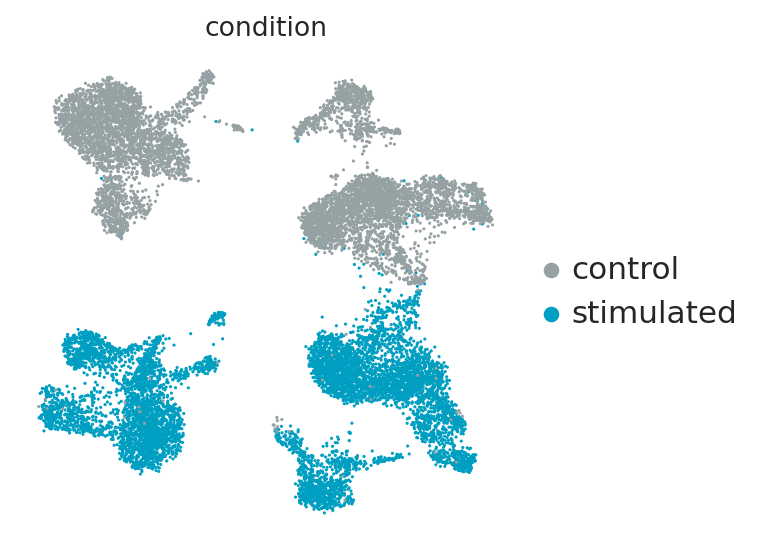

In [30]:
sc.pp.neighbors(study_A_data)
sc.tl.umap(study_A_data)
sc.pl.umap(study_A_data, color=[config.CONDITION_COL],
           legend_fontsize=14,
           palette=[config.CTRL_COLOR, config.TARGET_COLOR],
           save=f"_studyA_conditions.pdf",
           show=True, 
           frameon=False)

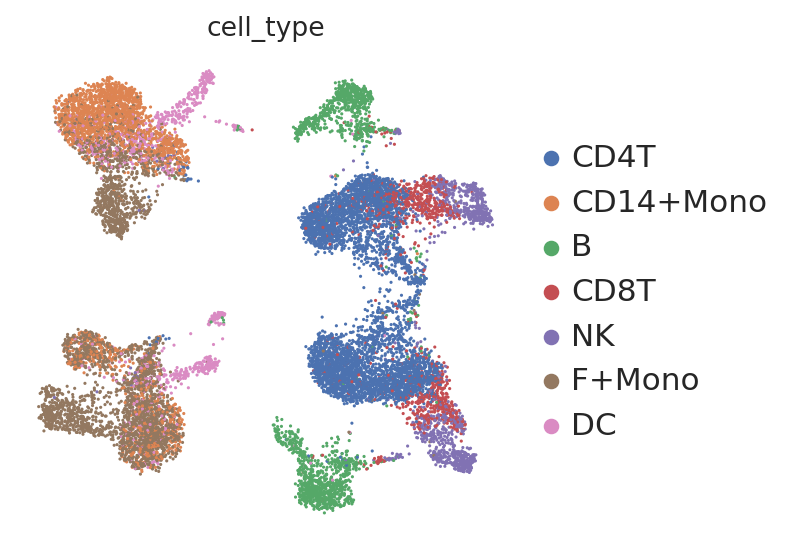

In [31]:
sc.pl.umap(study_A_data, color=[CLASS_COL],
           legend_fontsize=14,
           save=f"_studyA_celltypes.pdf",
           show=True, 
           frameon=False)

### Remove batch effect cross different study

In [5]:
study_A_part = study_A_data[study_A_data.obs[config.CONDITION_COL] == config.SOURCE_NAME].copy()
study_A_part.obs[config.CONDITION_COL] = "Study A"
study_B_part = study_B_data[study_B_data.obs[config.CONDITION_COL] == config.SOURCE_NAME].copy()
study_B_part.obs[config.CONDITION_COL] = "Study B"
mix_data = study_A_part.concatenate(study_B_part)

/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


... storing 'condition' as categorical
... storing 'study' as categorical


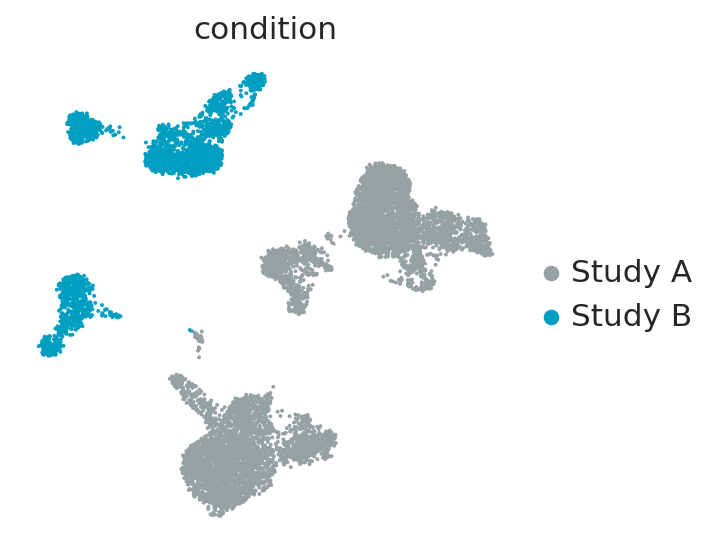

In [7]:
sc.pp.neighbors(mix_data)
sc.tl.umap(mix_data)
sc.pl.umap(mix_data, color=[config.CONDITION_COL],
           legend_fontsize=14,
           palette=[config.CTRL_COLOR, config.TARGET_COLOR],
           save=f"_mix_conditions.pdf",
           show=True, 
           frameon=False)

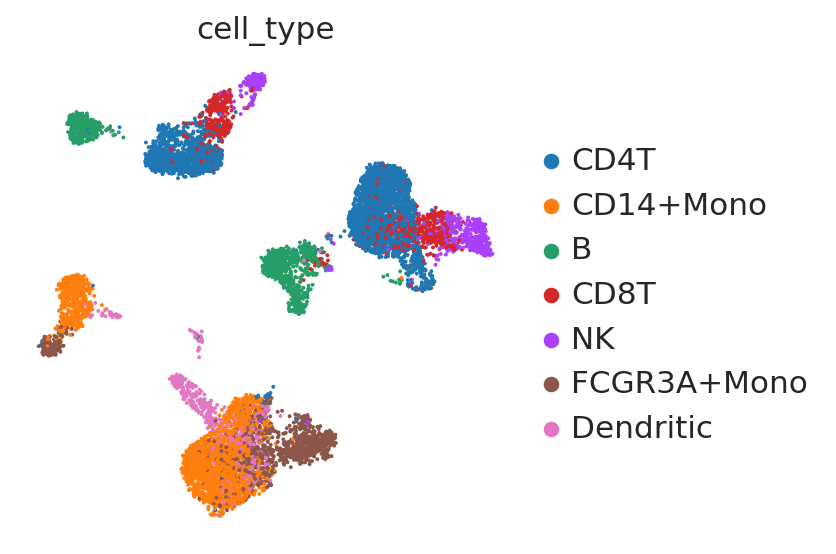

In [8]:
sc.pl.umap(mix_data, color=[CLASS_COL],
           legend_fontsize=14,
           save=f"_mix_celltypes.pdf",
           show=True, 
           frameon=False)

In [6]:
config.SOURCE_NAME = "Study B"
config.TARGET_NAME = "Study A"
source_data = mix_data[mix_data.obs.condition == config.SOURCE_NAME].copy()
target_data = mix_data[mix_data.obs.condition == config.TARGET_NAME].copy()
balance_source_data, balance_target_data = source_target_multiclass_alignment(
    source_data, 
    target_data,
    mertic="cosine",
    top_frac=1.0,
    class_col=CLASS_COL
    )

<AxesSubplot:>

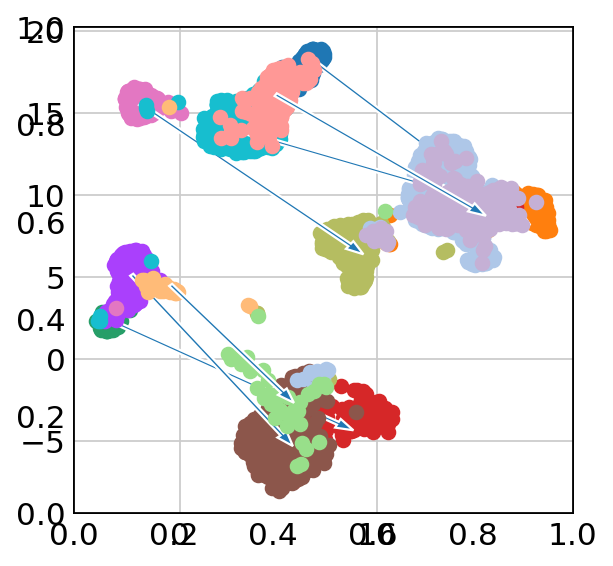

In [10]:
plot_alignment(
    balance_source_data, 
    balance_target_data, 
    class_col=CLASS_COL)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
jobid = getJobId()
print(jobid)
dataset=PertDataset(
    source=balance_source_data,
    target=balance_target_data,
    class_col=CLASS_COL)
train(
    jobid=jobid,
    dataset=dataset,
    padding_size=0,
    device=device,
    lr=config.LEARNING_RATE,
    d_model=config.D_MODEL,
    n_features=7000,
    n_heads=config.N_HEADS,
    n_layers=config.N_LAYERS,
    n_epoches=config.N_EPOCHES,
    update_lr_step=config.UPDATE_LR_STEP,
    train_batch_size=config.TRAIN_BATCH_SIZE,
    valid_batch_size=config.VALID_BATCH_SIZE,
    early_stop_patience=config.EARLY_STOP_PATIENCE,
    early_stop_min_delta=config.EARLY_STOP_MIN_DELTA,
    exp_scheduler_gamma=config.EXP_SCHEDULER_GAMMA,
    seed=config.GLOBAL_SEED,
    pretrain_path=None
)

20221015-202704-615


Fold 01 batch 017/017:  70%|███████   | 176/250 [16:09<06:47,  5.51s/it, lr=0.000843, max_memo_res=2.37GB, memo_res=350.00MB, pearson=0.987, pid=10032, train_loss=0.622, valid_loss=0.784]

Early stopping at epoch 176 for fold 1


In [8]:
jobid = "20221015-202704-615"
model = PertNet(config.D_MODEL, 7000, config.N_HEADS, config.N_LAYERS, 0)
model.device = device
loadTorchModule(model, f"models/scPert/{jobid}/{PertNet.__name__}_1.pt")
predict_data = model.predict(source_data, CLASS_COL)
predict_data.obs[config.CONDITION_COL] = "scPert"

2022-10-21 18:52:39,868 - loadTorchModule - INFO - model models/scPert/20221015-202704-615/PertNet_1.pt loaded


/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
... storing 'condition' as categorical
... storing 'study' as categorical


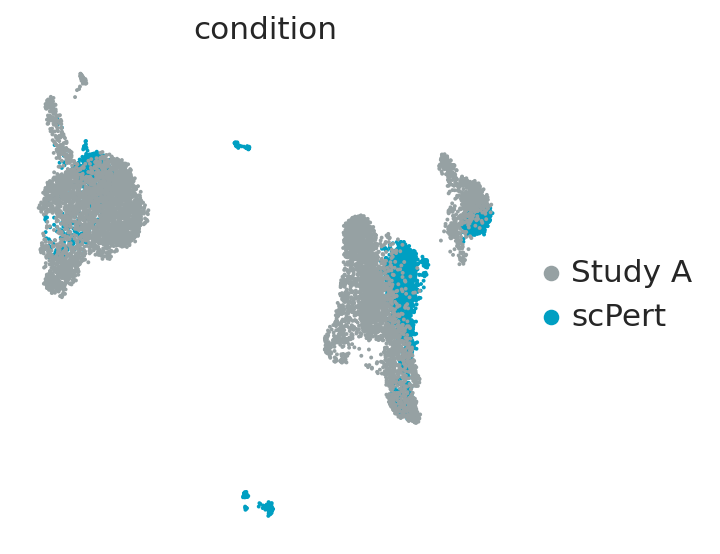

In [19]:
batch_removal_mix_data = predict_data.concatenate(target_data)
sc.pp.neighbors(batch_removal_mix_data)
sc.tl.umap(batch_removal_mix_data)
sc.pl.umap(batch_removal_mix_data, color=[config.CONDITION_COL],
            legend_fontsize=14,
            palette=[config.CTRL_COLOR, config.TARGET_COLOR],
            save=f"_batch_removal_conditions.pdf",
            show=True, 
            frameon=False)

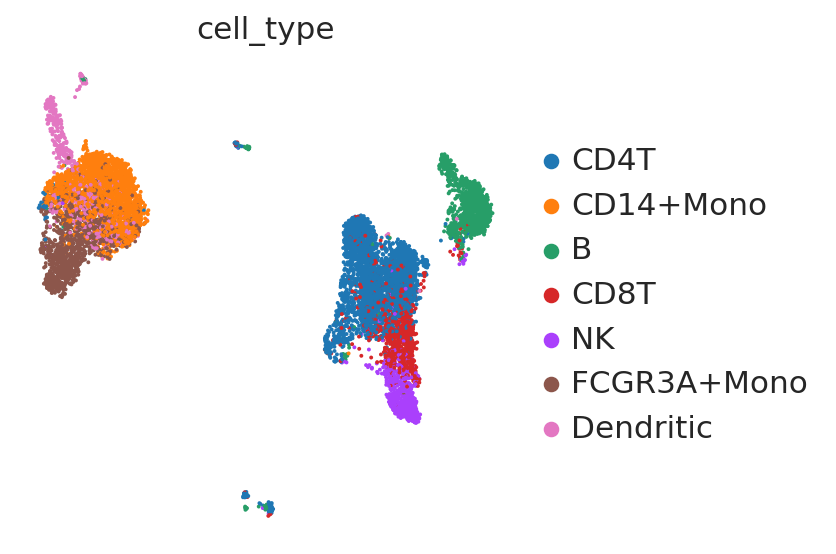

In [20]:
sc.pl.umap(batch_removal_mix_data, color=[CLASS_COL],
           legend_fontsize=14,
           save=f"_batch_removal_celltypes.pdf",
           show=True, 
           frameon=False)

In [28]:
def plot_multiplot(source_data, target_data, save=None):
    fig, axs = plt.subplots(2, 4, figsize=(8, 4))
    axs = axs.flatten()
    plt.rcParams.update({'font.size': 10})
    sns.set(style="ticks", font_scale=1.0)
    for index, selected_cell in enumerate(["B", "CD4T", "CD8T", "CD14+Mono", "DC", "F+Mono", "NK", "all"]):
        if selected_cell != "all":
            p = source_data[source_data.obs[CLASS_COL] == selected_cell].copy()
            t = target_data[target_data.obs[CLASS_COL] == selected_cell].copy()
        else:
            p, t = source_data, target_data
        p, t = _pair_sample(p, t, random_state=config.GLOBAL_SEED)
        p, t = p.mean(), t.mean()
        axs[index].set_title(selected_cell, fontsize=10)
        axs[index].tick_params(labelsize=10)
        axs[index].set_yticks([])
        axs[index].set_xticks([])
        _plot_regression_plot(p, t, ax=axs[index], all_gene=True, fontsize=10, scatter_kwargs={"s": 10, "rasterized": True})
        axs[index].set_ylabel("")
        axs[index].set_xlabel("")
    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight")
    return fig

2022-10-21 19:29:17,616 - Visualization - WARNING - Warning: n_obs is too large, using 37 instead.


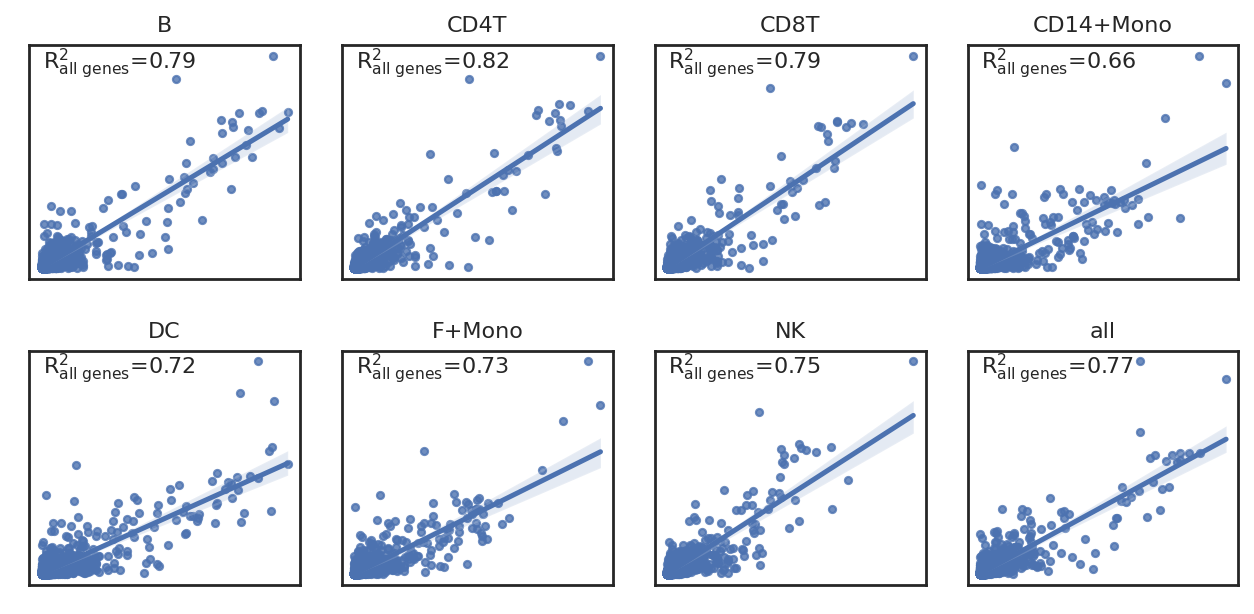

In [29]:
fig = plot_multiplot(source_data, target_data, save="figures/Mean-correlation-plot-B-A-original.pdf")

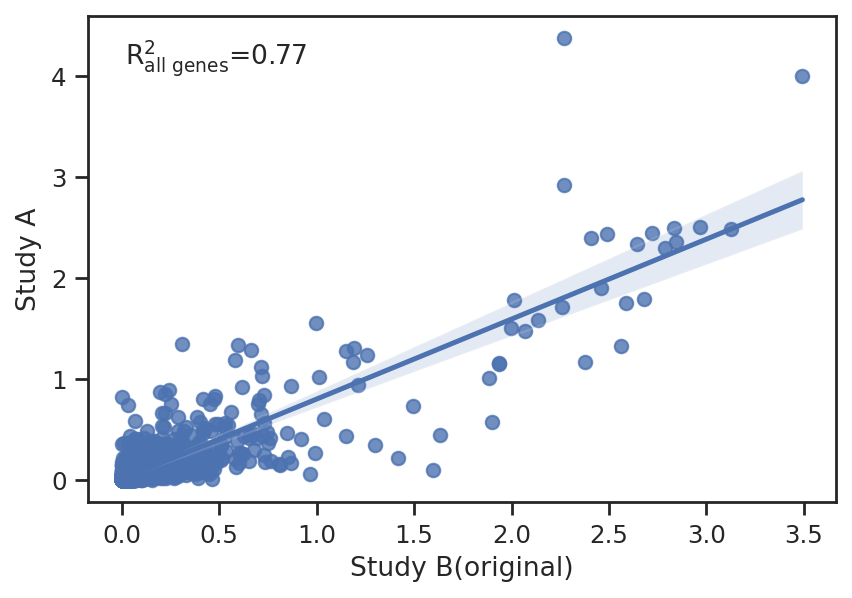

In [21]:
fig = plot_regression_plot(
    source_data,
    target_data,
    [],
    random_state=config.GLOBAL_SEED,
    x_label=config.SOURCE_NAME + "(original)",
    y_label=config.TARGET_NAME,
    save_path="figures/Mean-correlation-plot-B-A-original.pdf",
    figsize=(6,4)
)

2022-10-21 19:29:23,685 - Visualization - WARNING - Warning: n_obs is too large, using 37 instead.


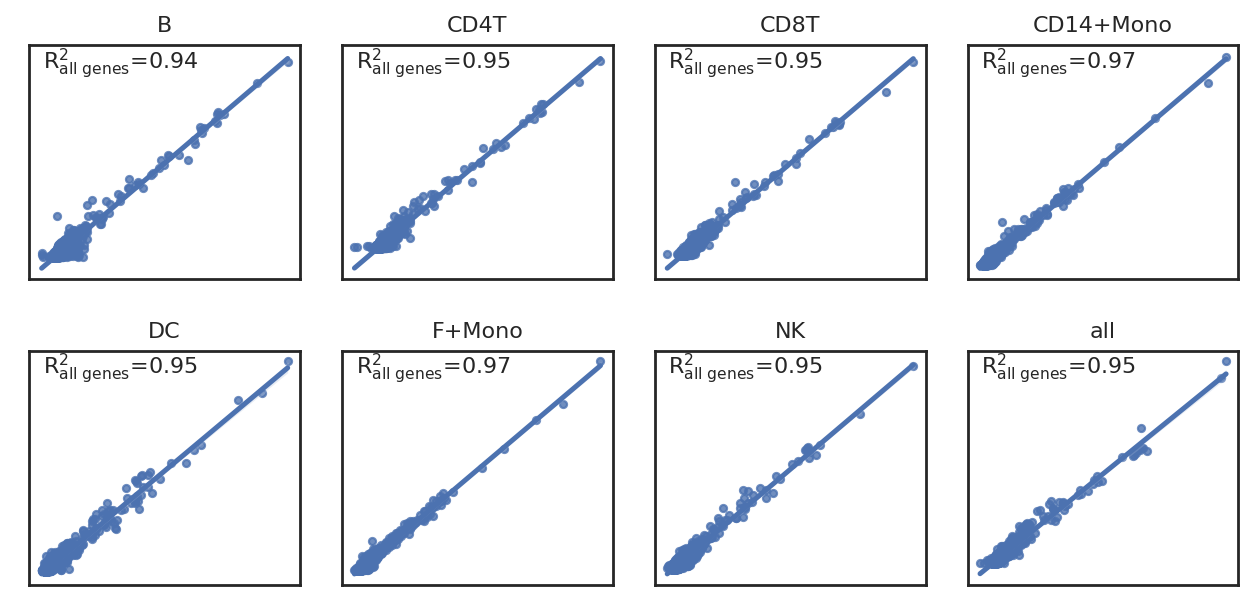

In [30]:
fig = plot_multiplot(predict_data, target_data, save="figures/Mean-correlation-plot-B-A-batch_removal.pdf")

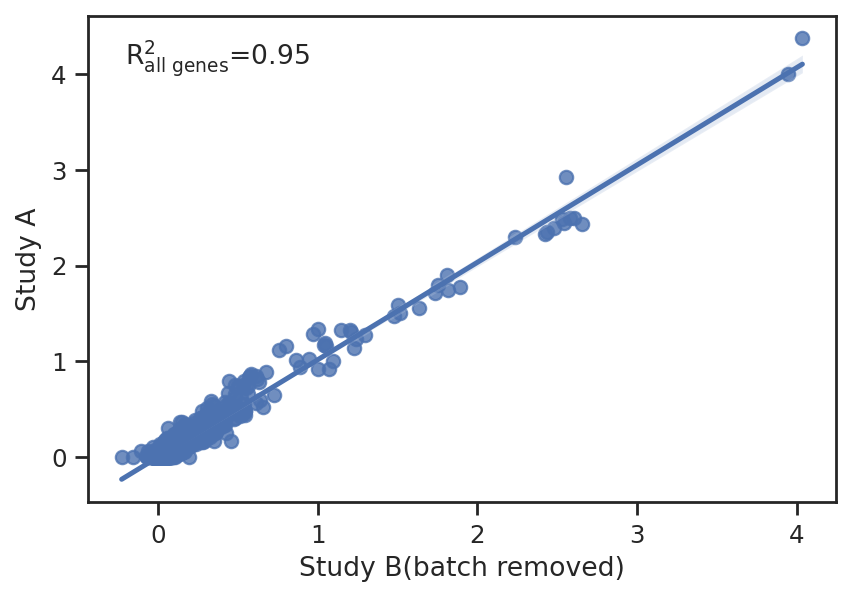

In [22]:
fig = plot_regression_plot(
    predict_data,
    target_data,
    [],
    random_state=config.GLOBAL_SEED,
    x_label=config.SOURCE_NAME + "(batch removed)",
    y_label=config.TARGET_NAME,
    save_path="figures/Mean-correlation-plot-B-A-batch_removal.pdf",
    figsize=(6,4)
)

### cross study perturbation prediction

build model base on Study A

In [31]:
config.SOURCE_NAME = "control"
config.TARGET_NAME = "stimulated"
source_A_data = study_A_data[study_A_data.obs.condition == config.SOURCE_NAME].copy()
target_A_data = study_A_data[study_A_data.obs.condition == config.TARGET_NAME].copy()
balance_source_A_data, balance_target_A_data = source_target_multiclass_alignment(
    source_A_data, 
    target_A_data,
    mertic="cosine",
    top_frac=1.0,
    class_col=CLASS_COL
    )

2022-10-21 20:14:12,723 - Preprocess - INFO - Sample for F+Mono
2022-10-21 20:14:16,587 - Preprocess - INFO - Sample for CD4T
2022-10-21 20:14:33,944 - Preprocess - INFO - Sample for DC
2022-10-21 20:14:34,469 - Preprocess - INFO - Sample for CD14+Mono
2022-10-21 20:14:35,469 - Preprocess - INFO - Sample for CD8T
2022-10-21 20:14:36,229 - Preprocess - INFO - Sample for B
2022-10-21 20:14:38,296 - Preprocess - INFO - Sample for NK


<AxesSubplot:>

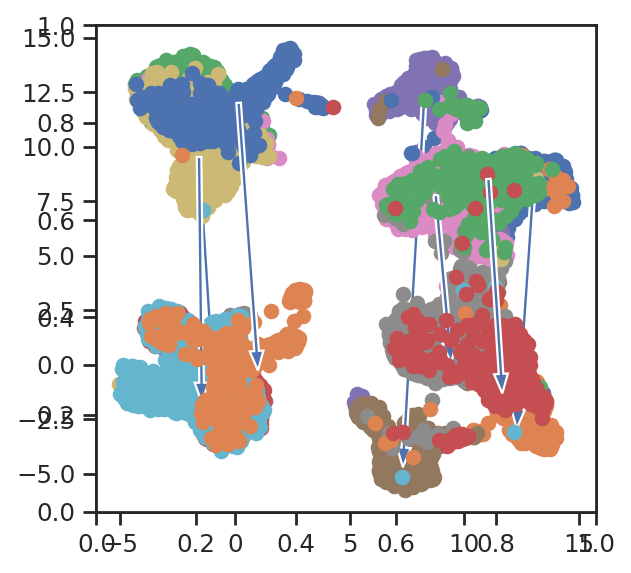

In [34]:
plot_alignment(
    balance_source_A_data, 
    balance_target_A_data, 
    class_col=CLASS_COL)

In [36]:
jobid = getJobId()
print(jobid)
dataset=PertDataset(
    source=balance_source_A_data,
    target=balance_target_A_data,
    class_col=CLASS_COL)
train(
    jobid=jobid,
    dataset=dataset,
    padding_size=0,
    device=device,
    lr=config.LEARNING_RATE,
    d_model=config.D_MODEL,
    n_features=7000,
    n_heads=config.N_HEADS,
    n_layers=config.N_LAYERS,
    n_epoches=config.N_EPOCHES,
    update_lr_step=config.UPDATE_LR_STEP,
    train_batch_size=config.TRAIN_BATCH_SIZE,
    valid_batch_size=config.VALID_BATCH_SIZE,
    early_stop_patience=config.EARLY_STOP_PATIENCE,
    early_stop_min_delta=config.EARLY_STOP_MIN_DELTA,
    exp_scheduler_gamma=config.EXP_SCHEDULER_GAMMA,
    seed=config.GLOBAL_SEED,
    pretrain_path=None)

20221020-205323-108


Fold 01 batch 036/036:  76%|███████▌  | 190/250 [34:33<10:54, 10.91s/it, lr=0.000826, max_memo_res=2.38GB, memo_res=726.00MB, pearson=0.994, pid=7872, train_loss=0.48, valid_loss=0.6]   

Early stopping at epoch 190 for fold 1


In [32]:
jobid = "20221020-205323-108"
model = PertNet(config.D_MODEL, 7000, config.N_HEADS, config.N_LAYERS, 0)
model.device = device
loadTorchModule(model, f"models/scPert/{jobid}/{PertNet.__name__}_1.pt")
predict_B_stim_data = model.predict(predict_data, CLASS_COL)
predict_B_stim_data.obs[config.CONDITION_COL] = "scPert"

2022-10-21 20:14:53,594 - loadTorchModule - INFO - model models/scPert/20221020-205323-108/PertNet_1.pt loaded


In [33]:
predict_B_stim_data.X = predict_B_stim_data.X - predict_data.X + study_B_data.X

In [40]:
merge_B_data = predict_B_stim_data.concatenate(study_B_data)

/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


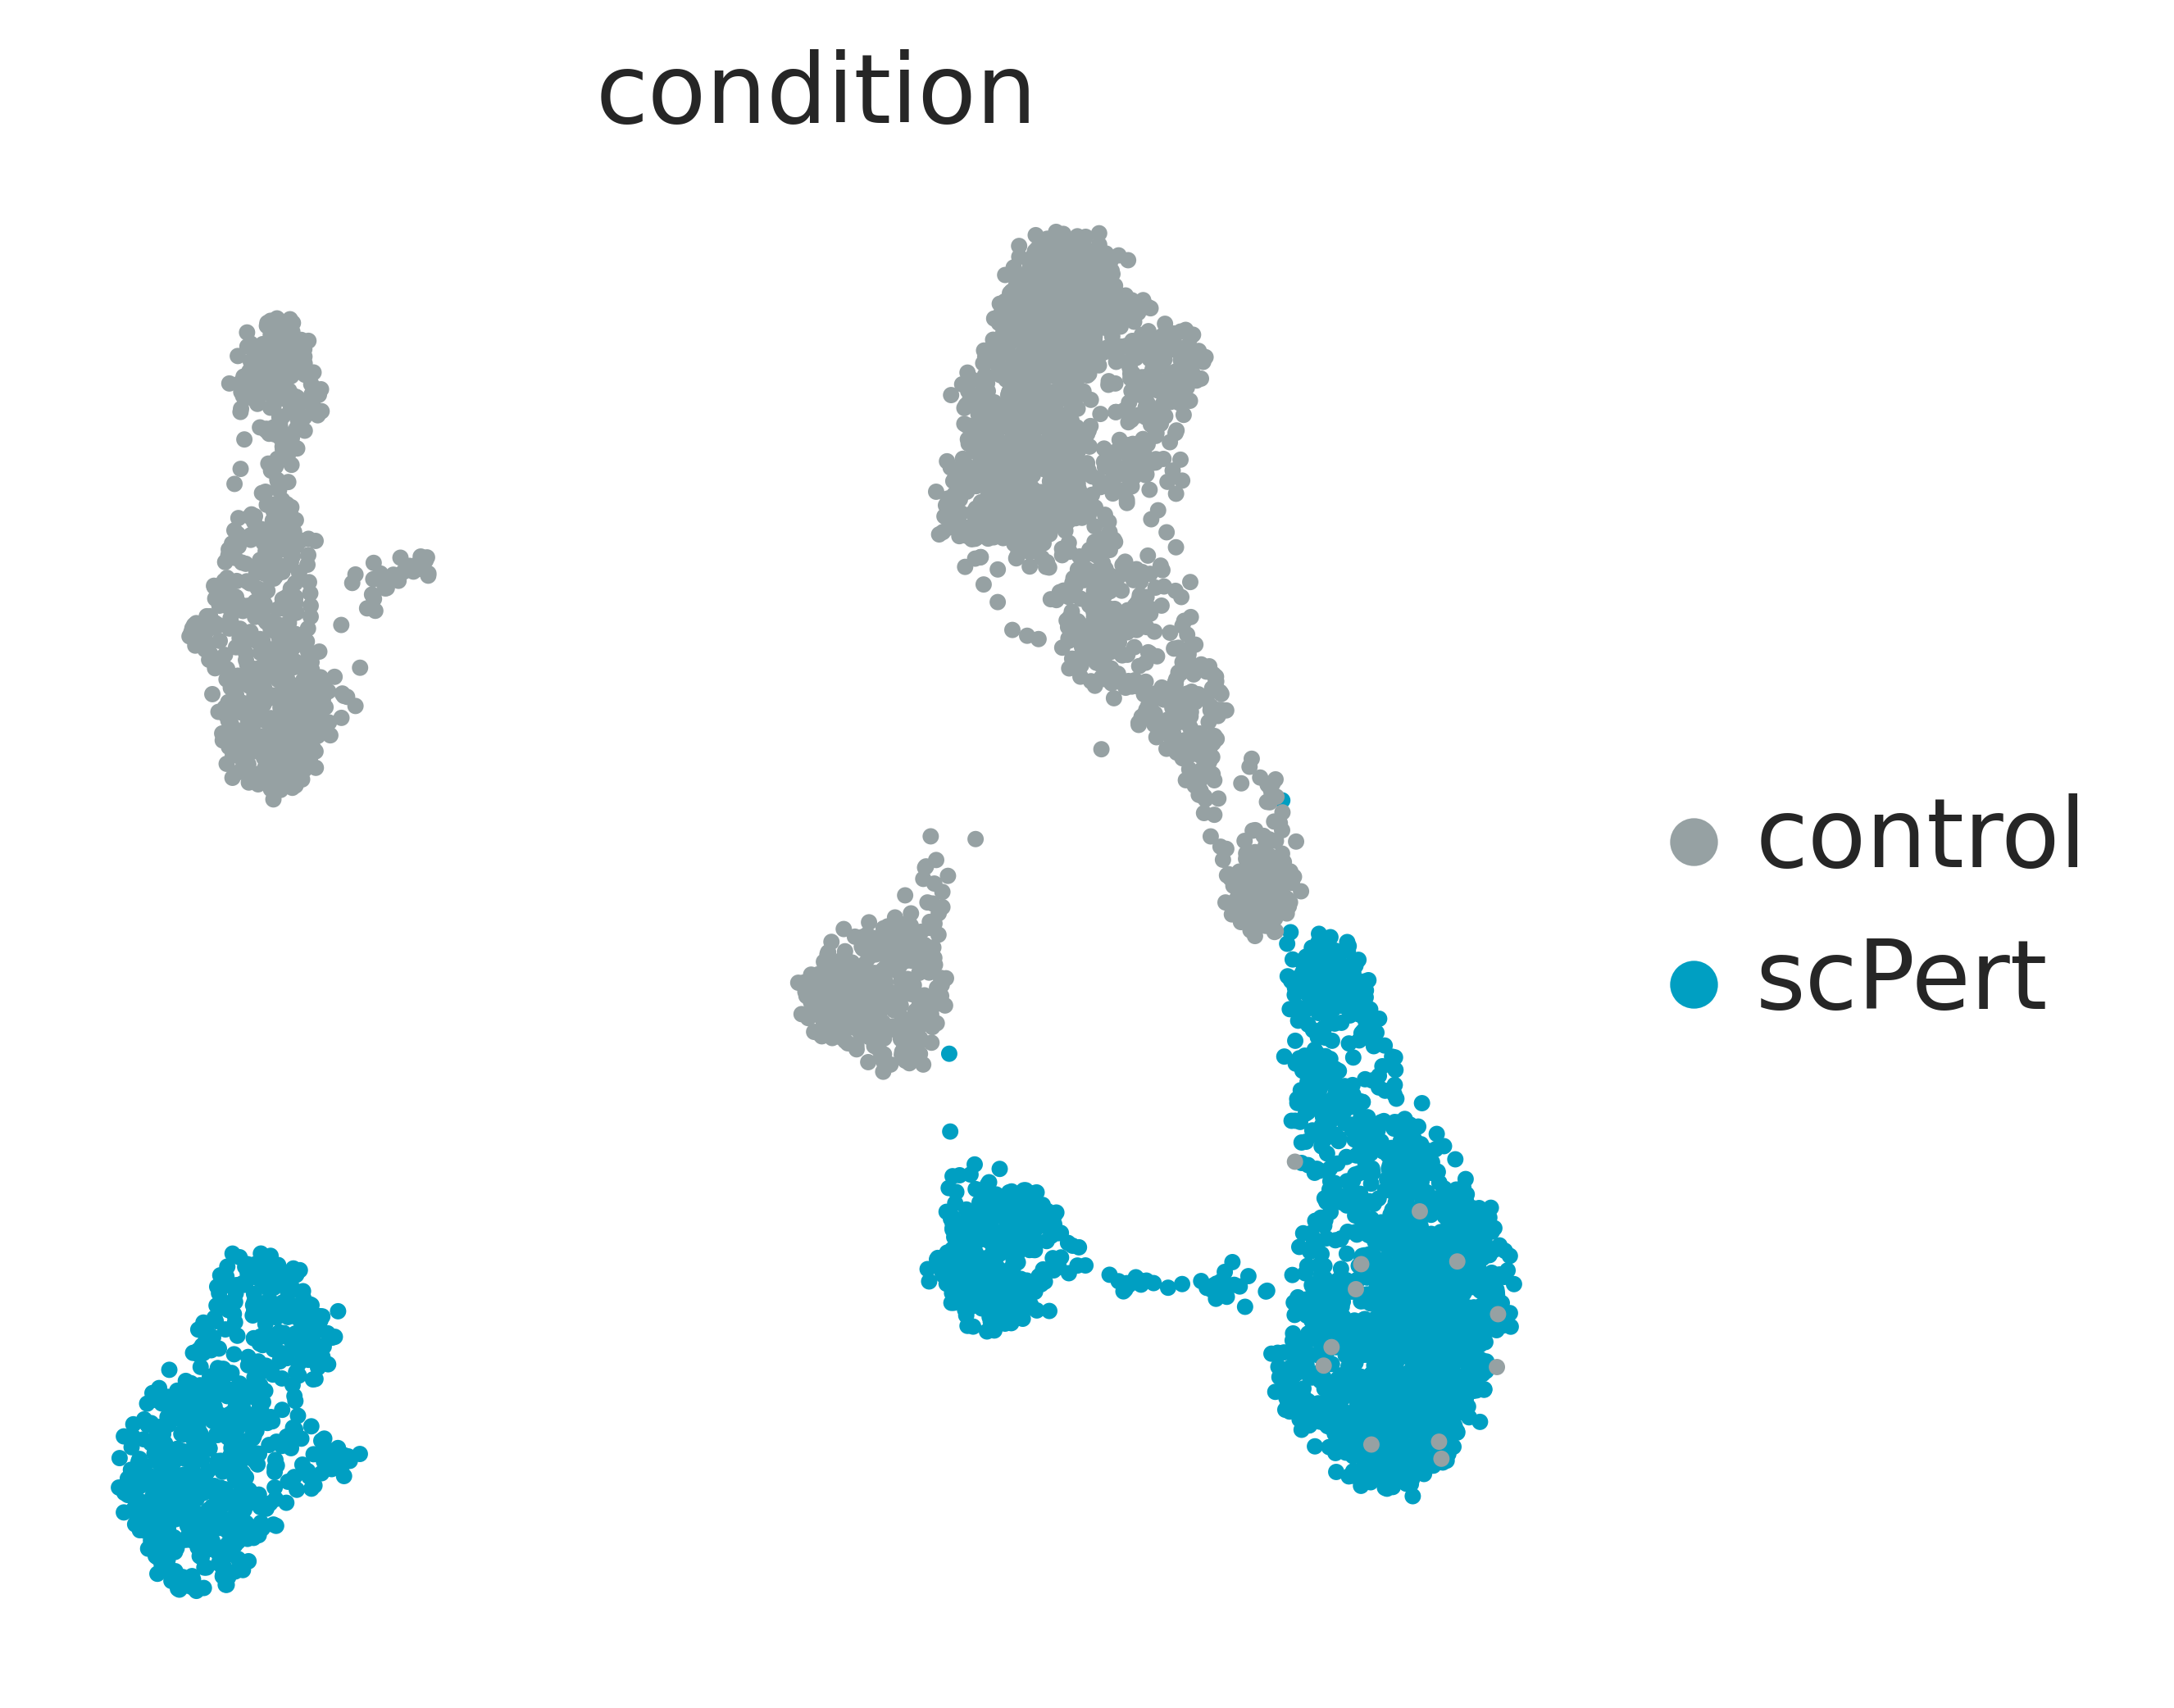

In [46]:
# sc.pp.neighbors(merge_B_data)
# sc.tl.umap(merge_B_data)
sc.pl.umap(merge_B_data, color=[config.CONDITION_COL],
            legend_fontsize=14,
            palette=[config.CTRL_COLOR, config.TARGET_COLOR],
            save=f"_study_B_predict_conditions.pdf",
            show=True, 
            frameon=False)

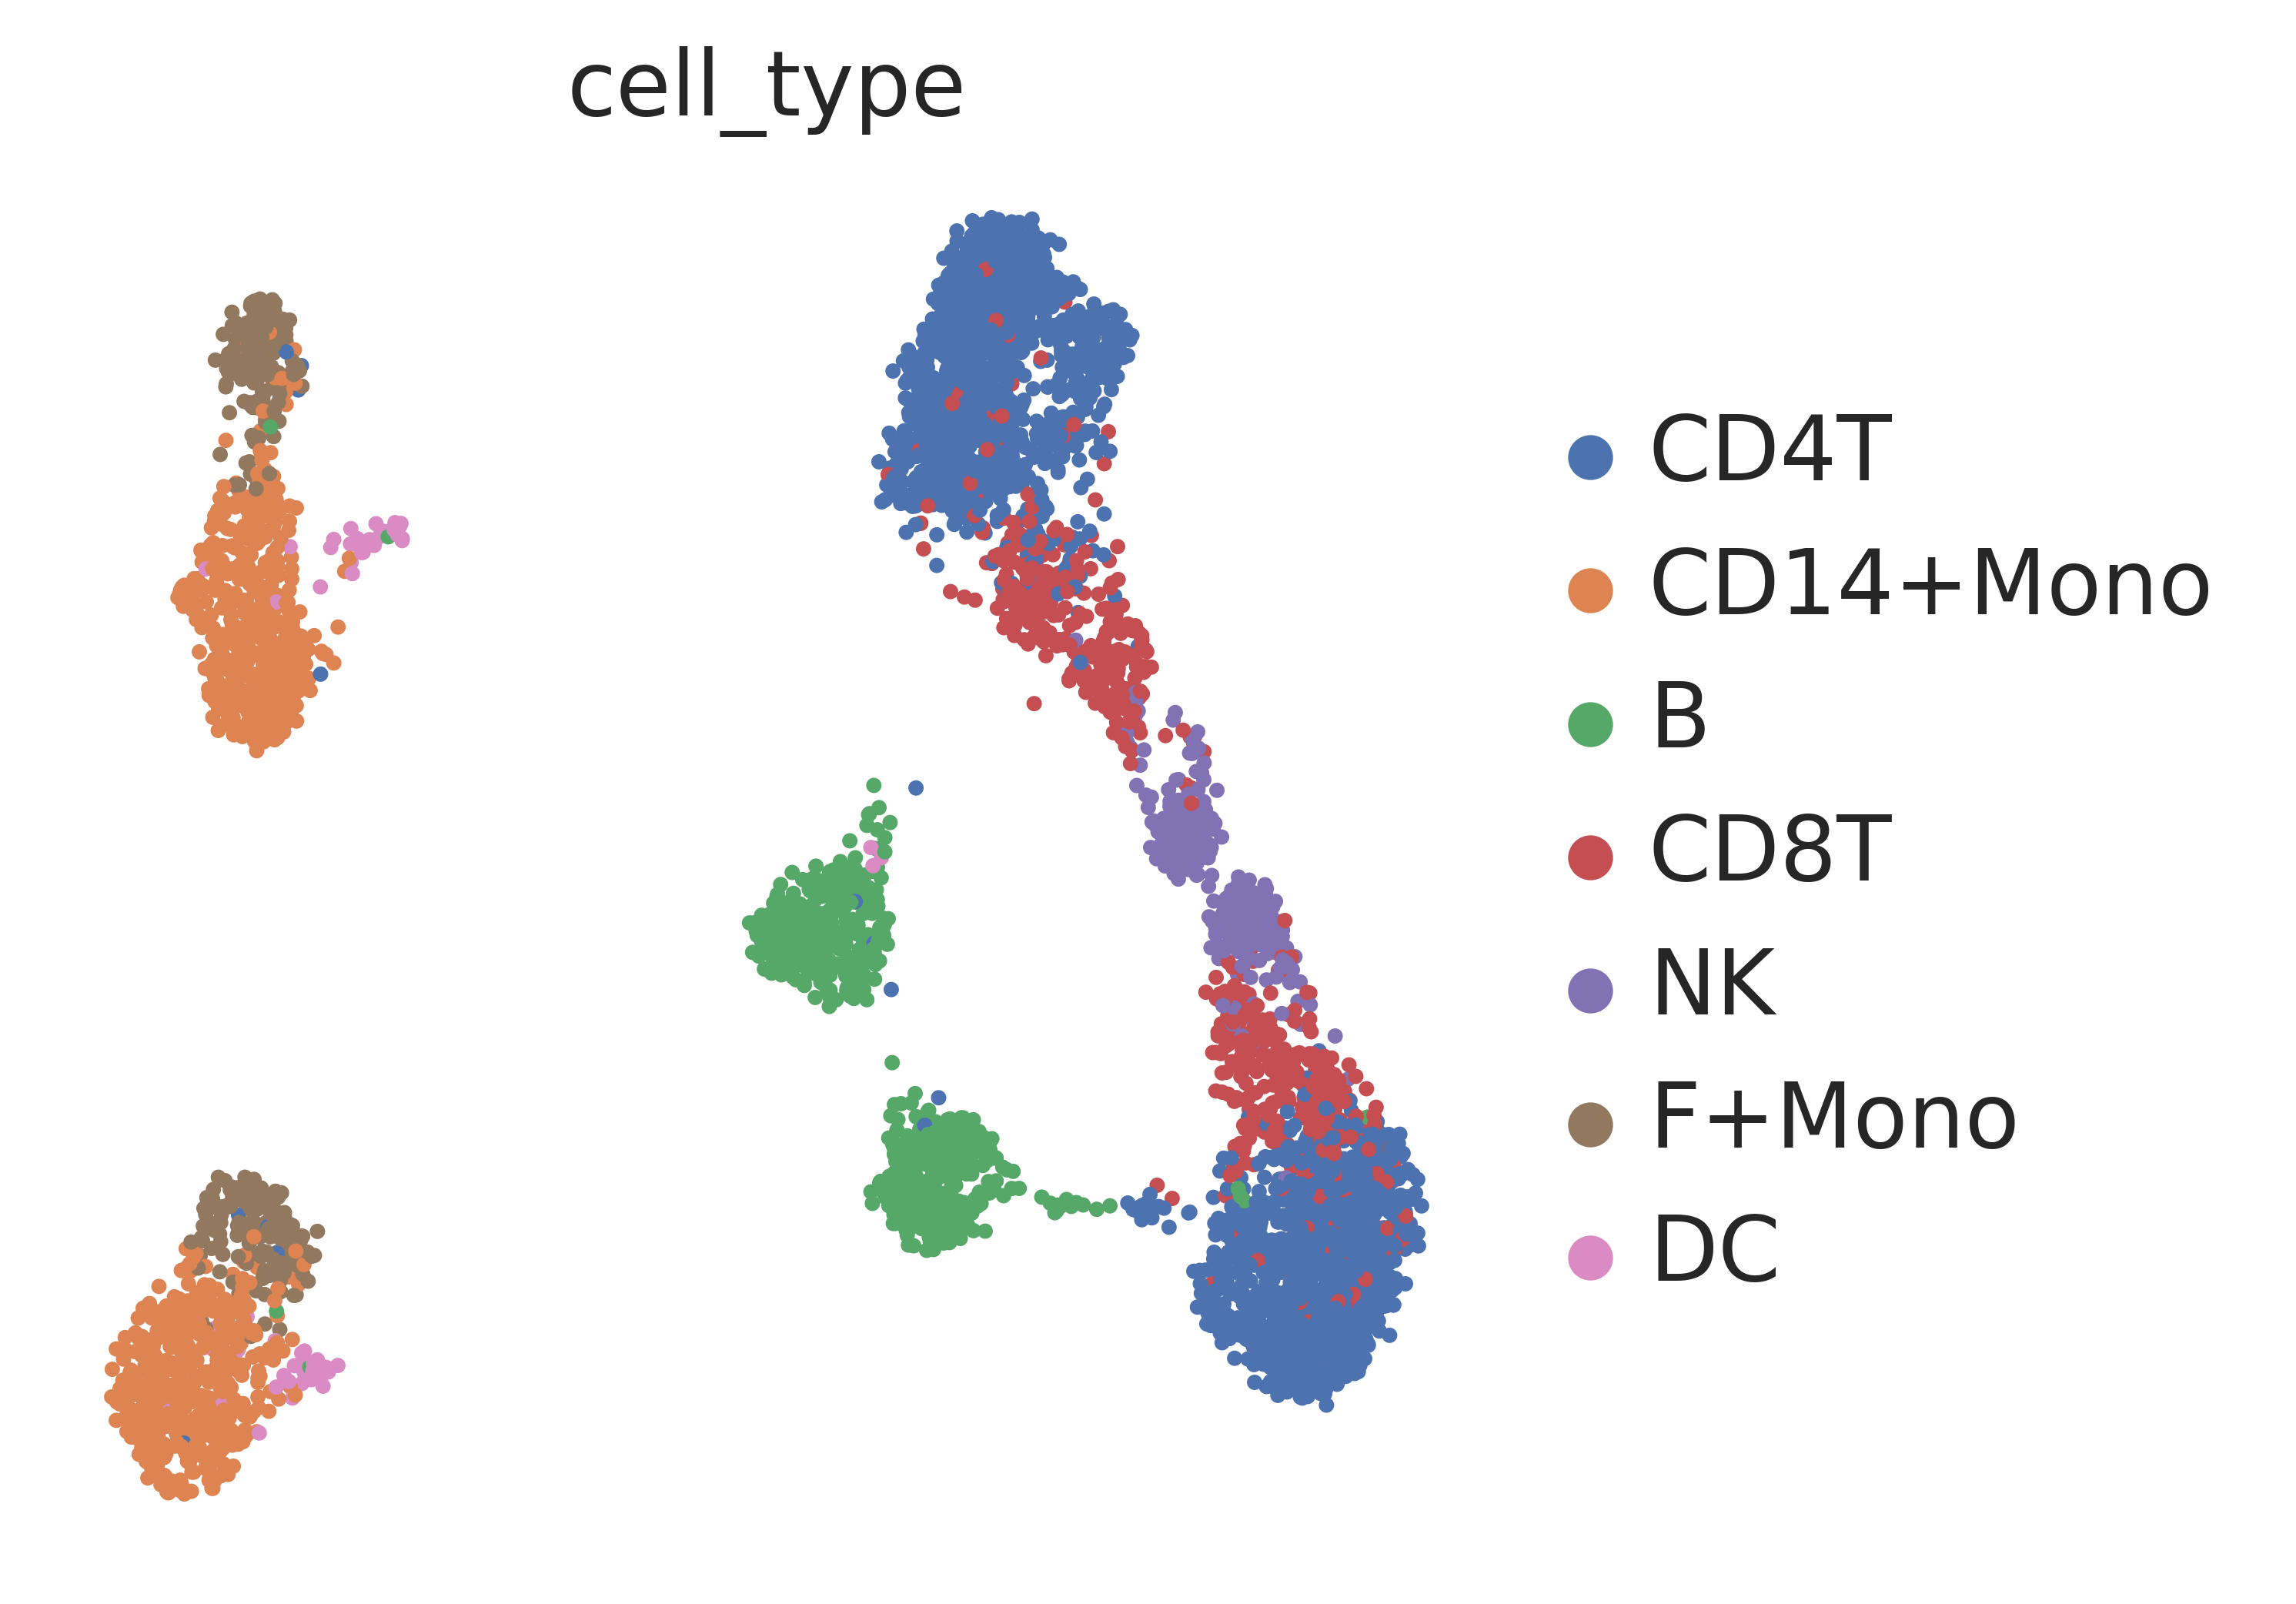

In [47]:
sc.pl.umap(merge_B_data, color=[CLASS_COL],
            legend_fontsize=14,
            save="_study_B_predict_celltypes.pdf",
            show=True, 
            frameon=False)

2022-10-21 20:16:13,216 - Visualization - WARNING - Warning: n_obs is too large, using 37 instead.


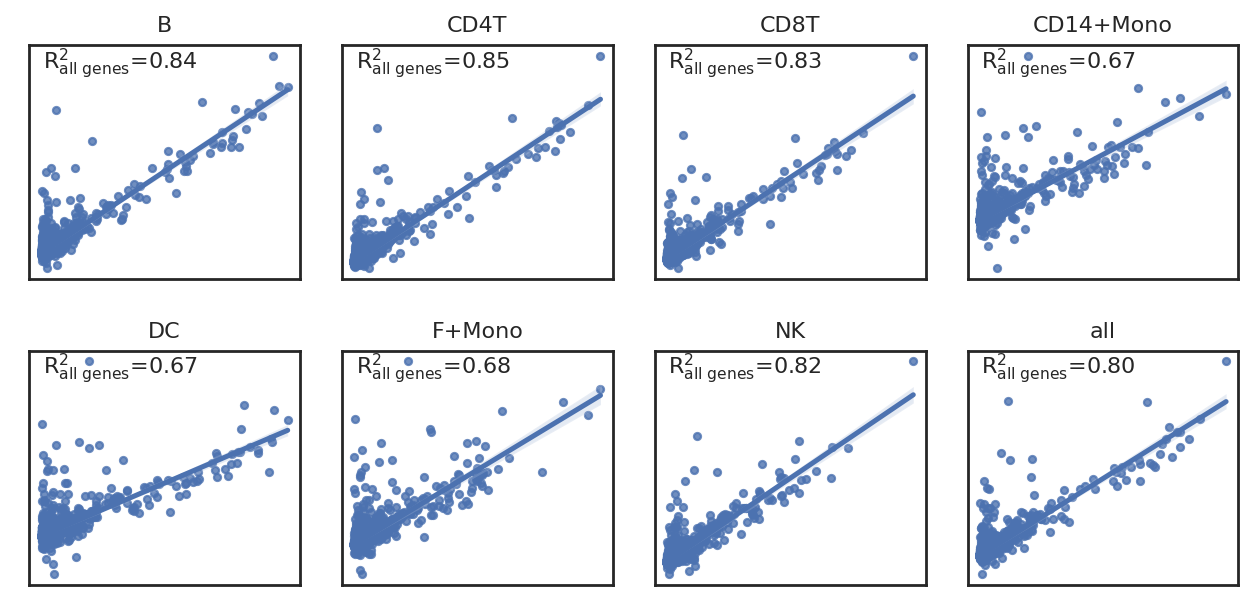

In [34]:
fig = plot_multiplot(study_B_data, predict_B_stim_data, save="figures/Mean-correlation-plot-B-B_by_cell.pdf")

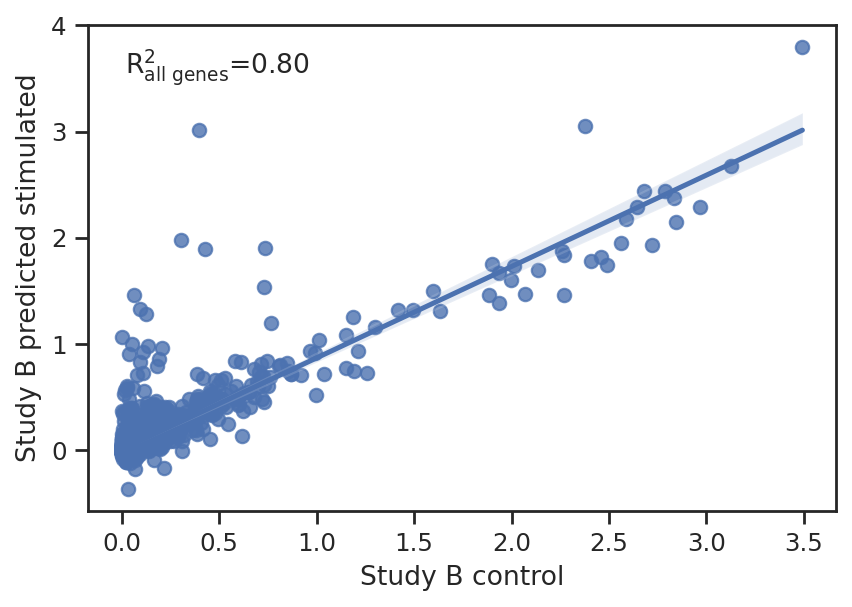

In [55]:
fig = plot_regression_plot(
    study_B_data,
    predict_B_stim_data,
    [],
    x_label="Study B control",
    y_label="Study B predicted stimulated",
    random_state=config.GLOBAL_SEED,
    save_path="figures/Mean-correlation-plot-B-B.pdf",
    figsize=(6,4)
)

2022-10-21 20:17:34,922 - Visualization - WARNING - Warning: n_obs is too large, using 37 instead.


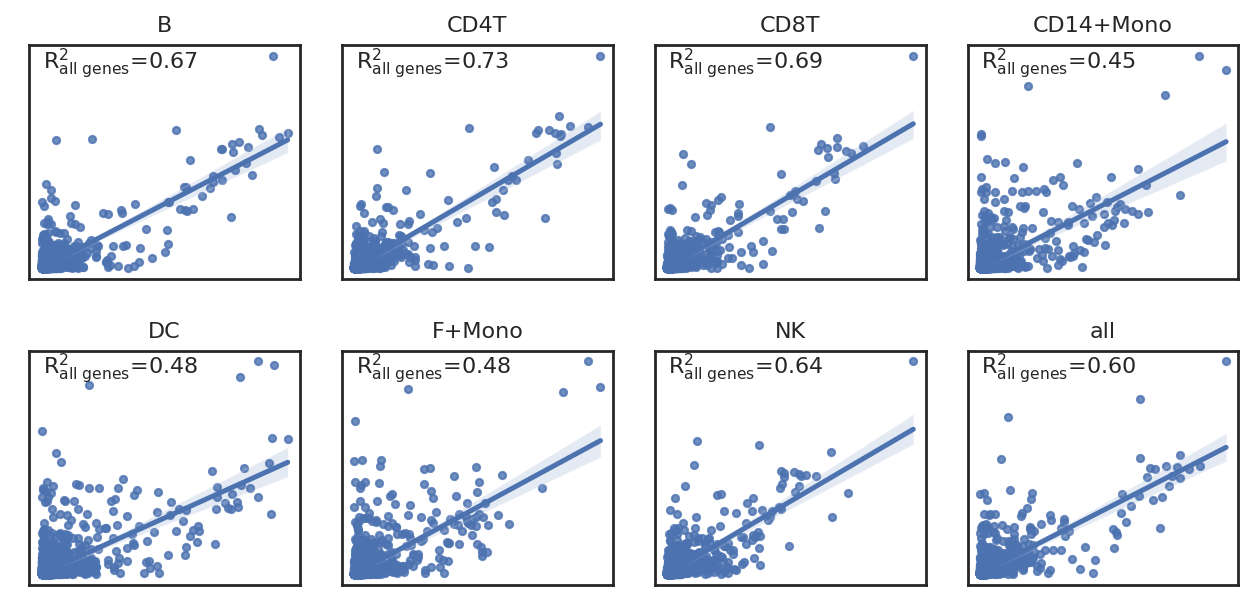

In [35]:
fig = plot_multiplot(study_B_data, target_A_data, save="figures/Mean-correlation-plot-B-A_by_cell.pdf")

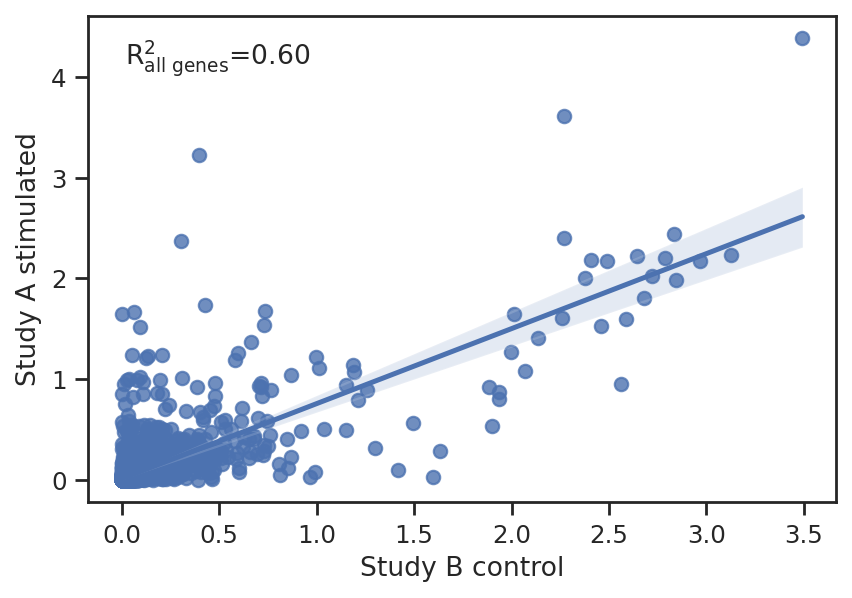

In [56]:
fig = plot_regression_plot(
    study_B_data,
    target_A_data,
    [],
    x_label="Study B control",
    y_label="Study A stimulated",
    random_state=config.GLOBAL_SEED,
    save_path="figures/Mean-correlation-plot-B-A.pdf",
    figsize=(6,4)
)

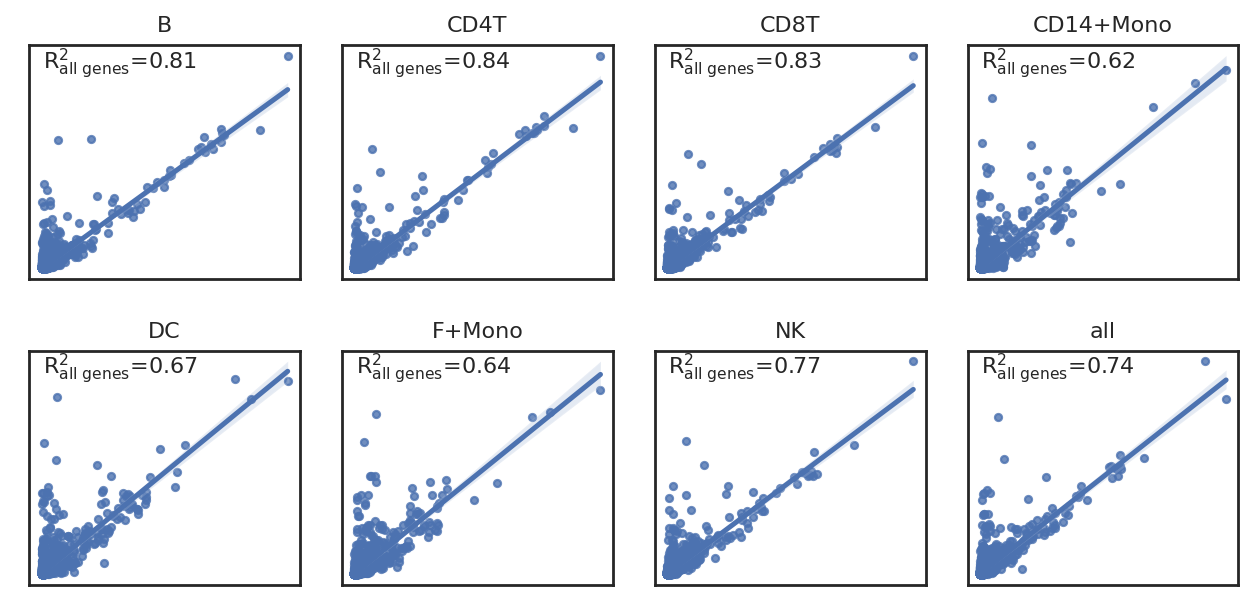

In [36]:
fig = plot_multiplot(source_A_data, target_A_data, save="figures/Mean-correlation-plot-A-A_by_cell.pdf")

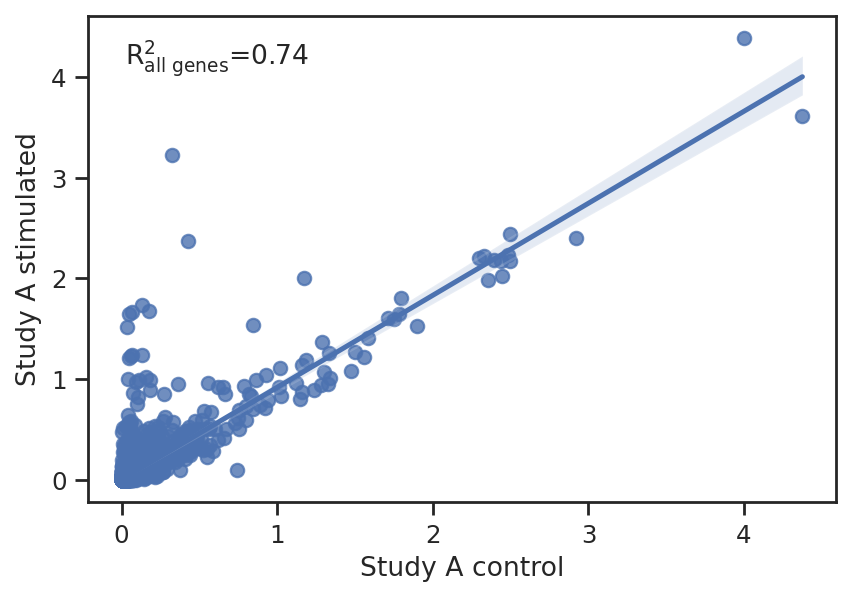

In [57]:
fig = plot_regression_plot(
    source_A_data,
    target_A_data,
    [],
    x_label="Study A control",
    y_label="Study A stimulated",
    random_state=config.GLOBAL_SEED,
    save_path="figures/Mean-correlation-plot-A-A.pdf",
    figsize=(6,4)
)

In [60]:
import matplotlib
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)

def grouped_barplot(df, cat, subcat, val, err=None, filename=None, put_label=False, legend=False, ylim=None):
    plt.close("all")
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=30)
    u = df[cat].unique()
    subx = df[subcat].unique()
    x_pos = np.arange(0, len(subx)*len(u), len(subx))
    plt.figure(figsize=(12, 8))
    if ylim:
        plt.ylim(*ylim)
    plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values if err else None)
        if err:
            a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
            plt.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=25)
    plt.xticks(x_pos+(len(subx) - 1) / 2.5, u, rotation=90)
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, facecolor='auto', edgecolor='auto')
    plt.show()

In [62]:
hist_data = {
    "Value": [0.84,0.85,0.83,0.67,0.67,0.68,0.82, 0.80] + [0.67,0.73,0.69,0.45,0.48,0.48,0.64, 0.60],
    "Method": ["Prediction"] * 8 + ["Study A"] * 8,
    "cell_types": ["B", "CD4T", "CD8T", "CD14+Mono", "DC", "F+Mono", "NK", "Average"] * 2
}
hist_data = pd.DataFrame(hist_data)

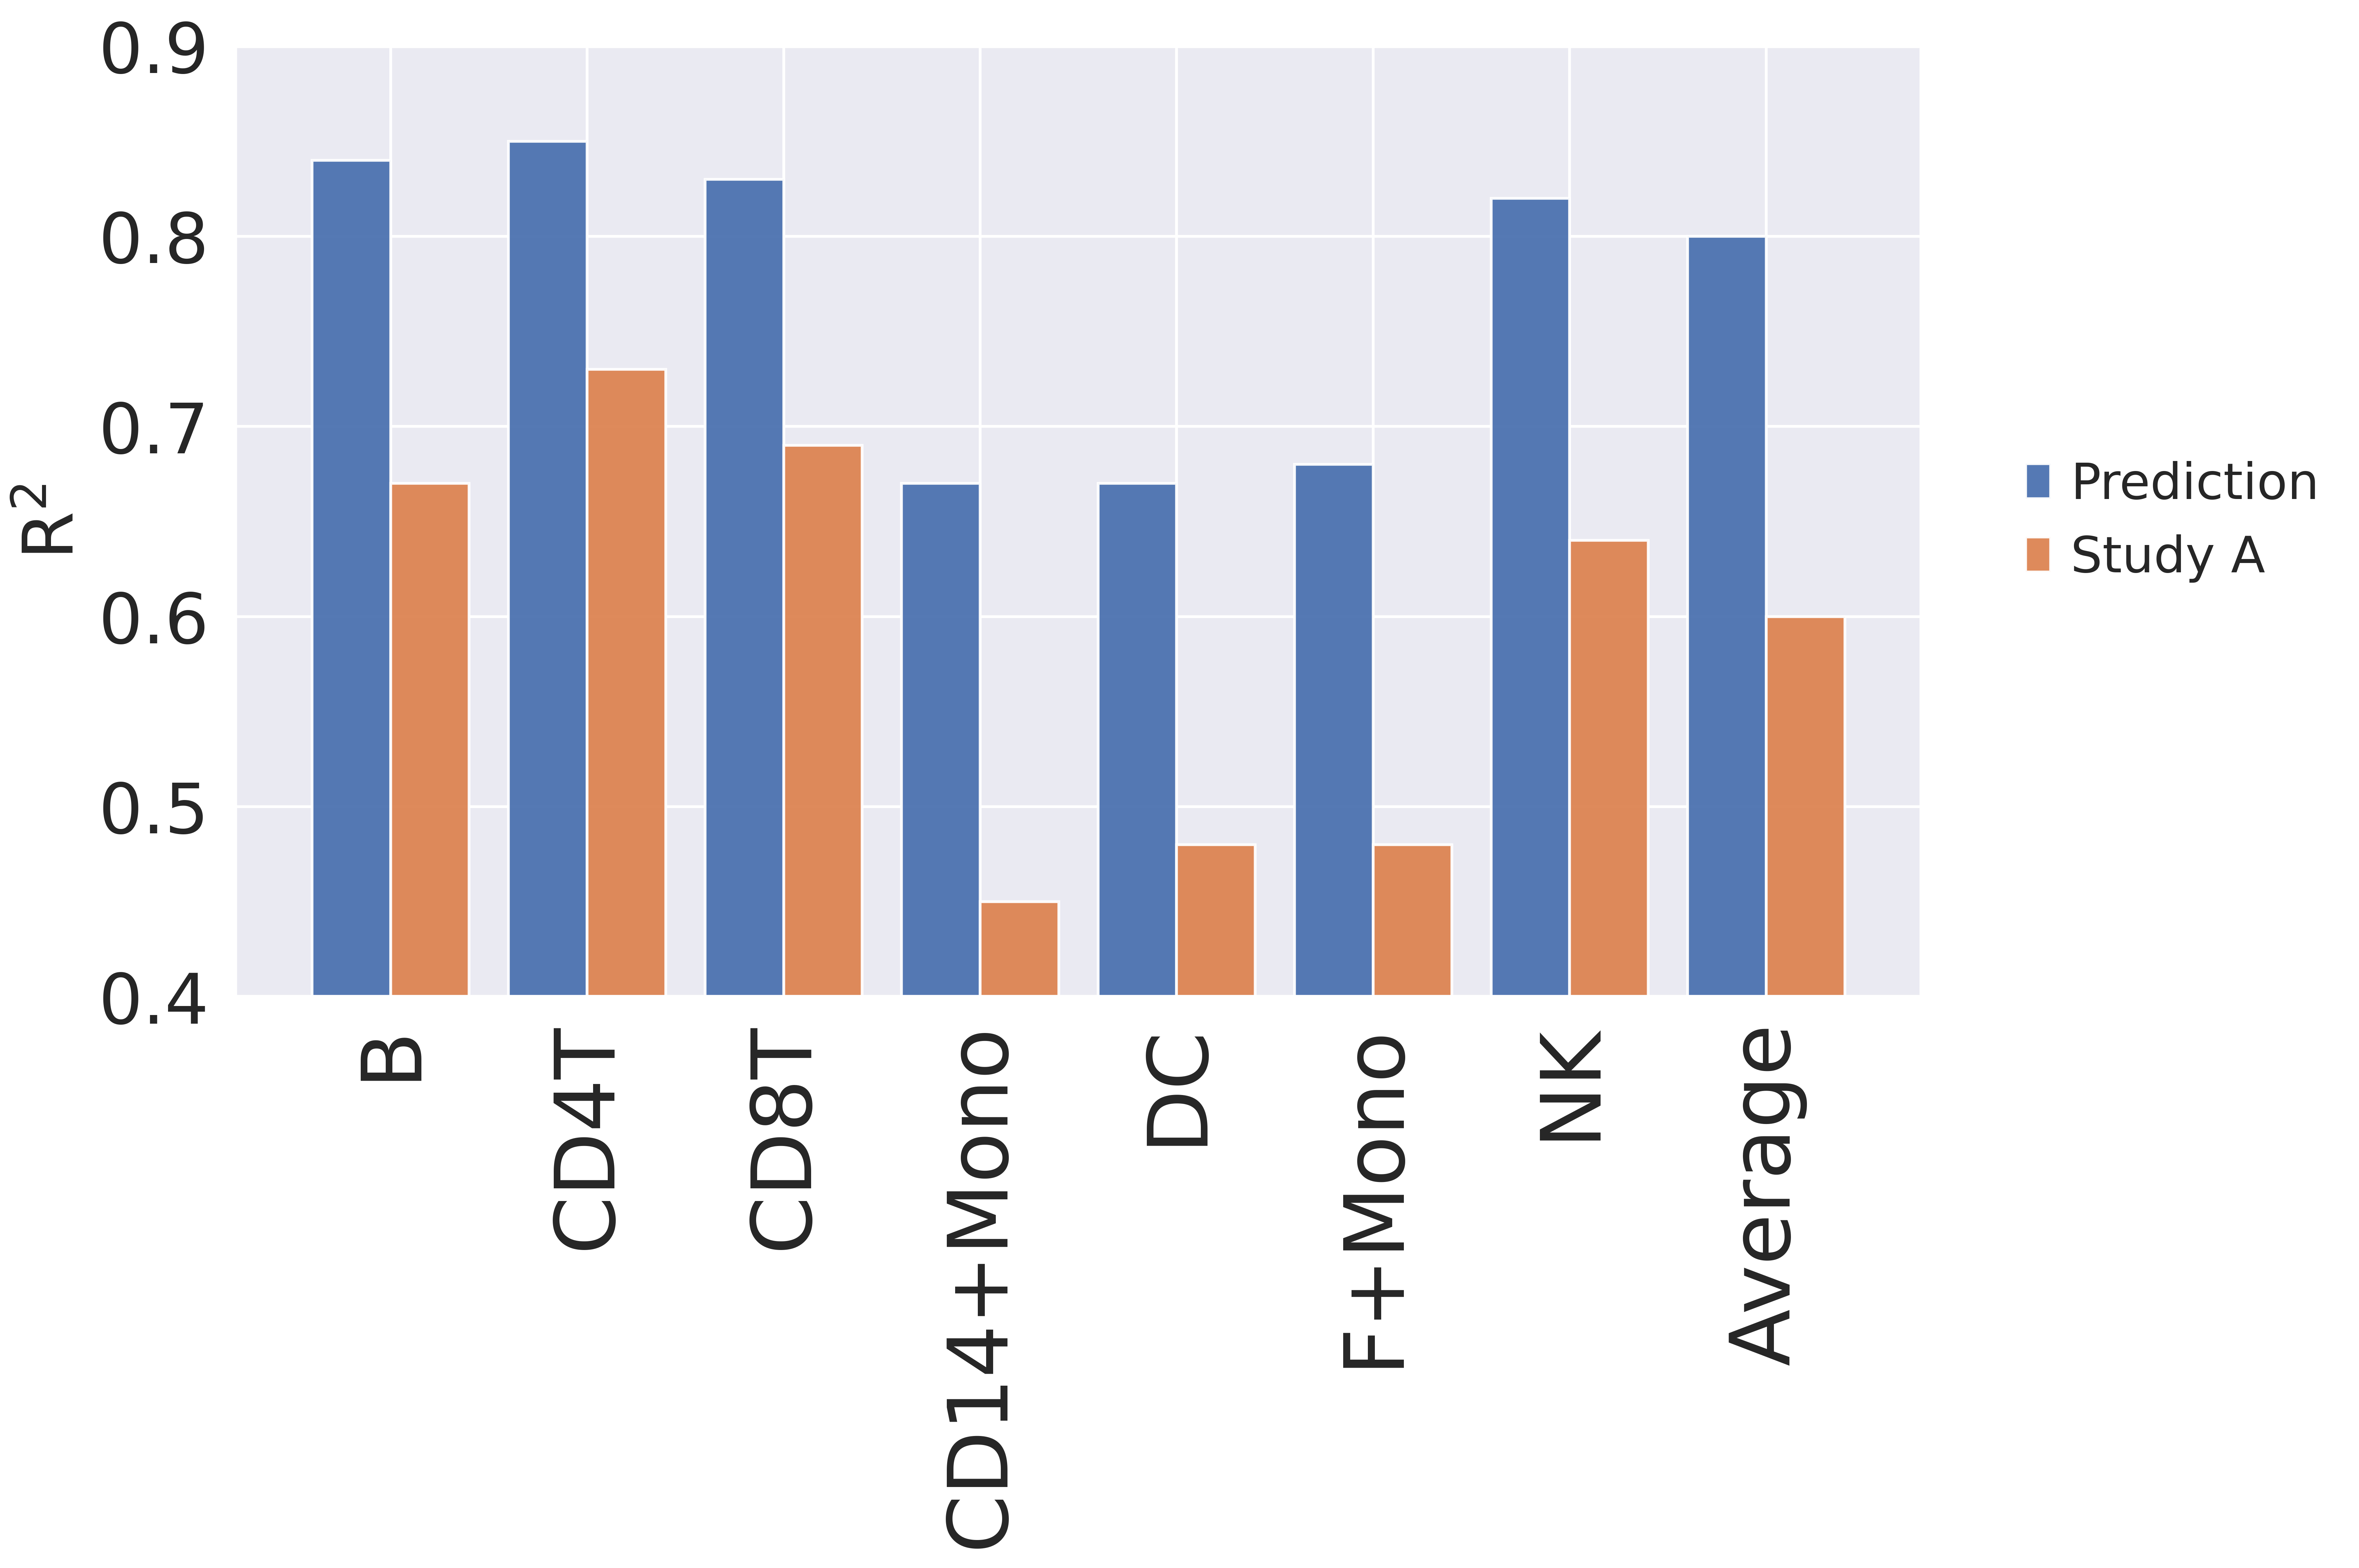

In [63]:
sns.set()
grouped_barplot(
    hist_data, 
    "cell_types", 
    "Method", 
    "Value", 
    None, 
    legend=True, 
    filename="figures/Mean-R^2-histgram-B-A.pdf",
    ylim=(0.4, 0.9))

In [48]:
sc.tl.rank_genes_groups(study_A_data, groupby=config.CONDITION_COL, method="wilcoxon")
diff_genes_A = study_A_data.uns["rank_genes_groups"]["names"][config.TARGET_NAME][:100]

In [58]:
merge_study_B_data = study_B_data.concatenate(predict_B_stim_data)

/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [61]:
sc.tl.rank_genes_groups(merge_study_B_data, groupby=config.CONDITION_COL, method="wilcoxon")
diff_genes_B = merge_study_B_data.uns["rank_genes_groups"]["names"]["scPert"][:100]

In [63]:
diff_genes_A = set(diff_genes_A)
diff_genes_B = set(diff_genes_B)

In [64]:
common_diff_genes = diff_genes_A.intersection(diff_genes_B)

In [69]:
merge_list = [source_A_data.copy(), target_A_data.copy(), study_B_data.copy(), predict_B_stim_data.copy()]
merge_list[0].obs[config.CONDITION_COL] = "Study A control"
merge_list[1].obs[config.CONDITION_COL] = "Study A stimulated"
merge_list[2].obs[config.CONDITION_COL] = "Study B control"
merge_list[3].obs[config.CONDITION_COL] = "Study B predicted stimulated"
merge_data = sc.concat(merge_list)

In [79]:
merge_A_data = study_A_data.copy()
merge_A_data.obs[config.CONDITION_COL].replace({"control": "ctrl", "stimulated": "stim"}, inplace=True)
merge_A_data.obs["condition_cell_type"] = merge_A_data.obs[config.CONDITION_COL] + "_" + merge_A_data.obs[CLASS_COL].astype("object")

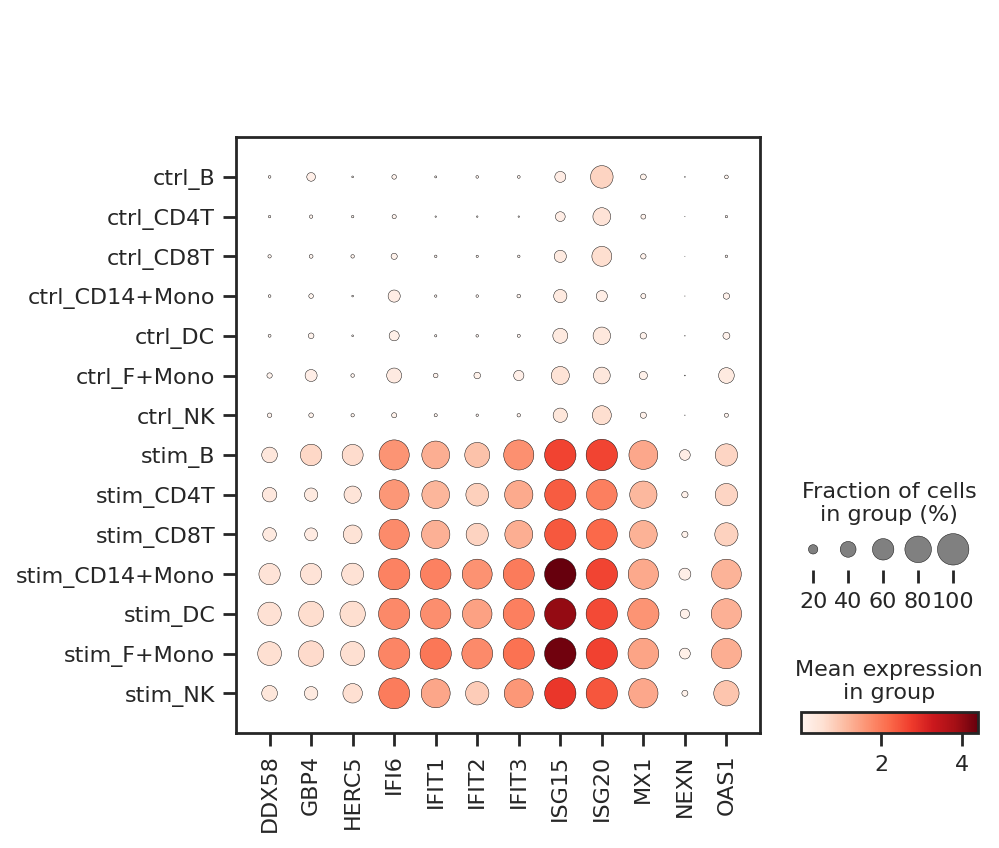

In [94]:
sc.pl.dotplot(merge_A_data, var_names=sorted(common_diff_genes), groupby="condition_cell_type", save="_cross_study_predict_DEGs(A).pdf", show=True)

In [86]:
merge_study_B_data.obs[config.CONDITION_COL].replace({"control": "ctrl", "scPert": "pred"}, inplace=True)
merge_study_B_data.obs[CLASS_COL].replace({"Dendritic": "DC", "FCGR3A+Mono": "F+Mono"}, inplace=True)
merge_study_B_data.obs["condition_cell_type"] = merge_study_B_data.obs[config.CONDITION_COL].astype("object") + "_" + merge_study_B_data.obs[CLASS_COL].astype("object")

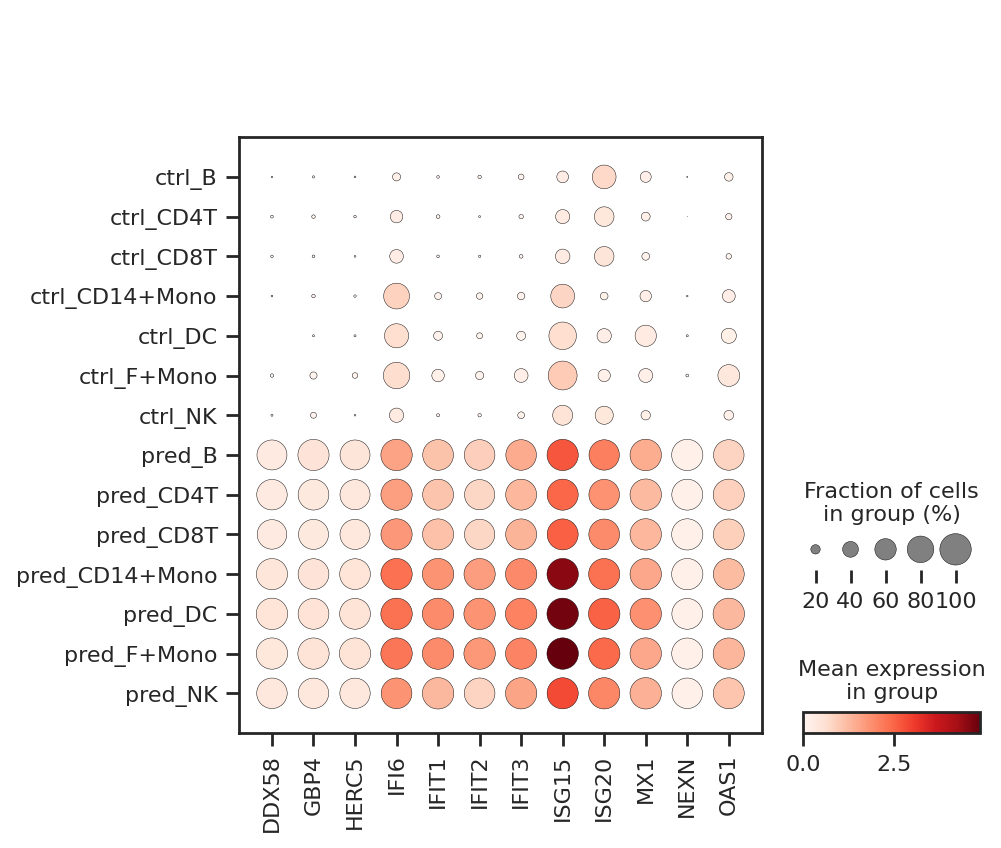

In [93]:
sc.pl.dotplot(merge_study_B_data, var_names=sorted(common_diff_genes), groupby="condition_cell_type", save="_cross_study_predict_DEGs(B).pdf", show=True)

... storing 'condition' as categorical
... storing 'study' as categorical
... storing 'condition_cell_type' as categorical


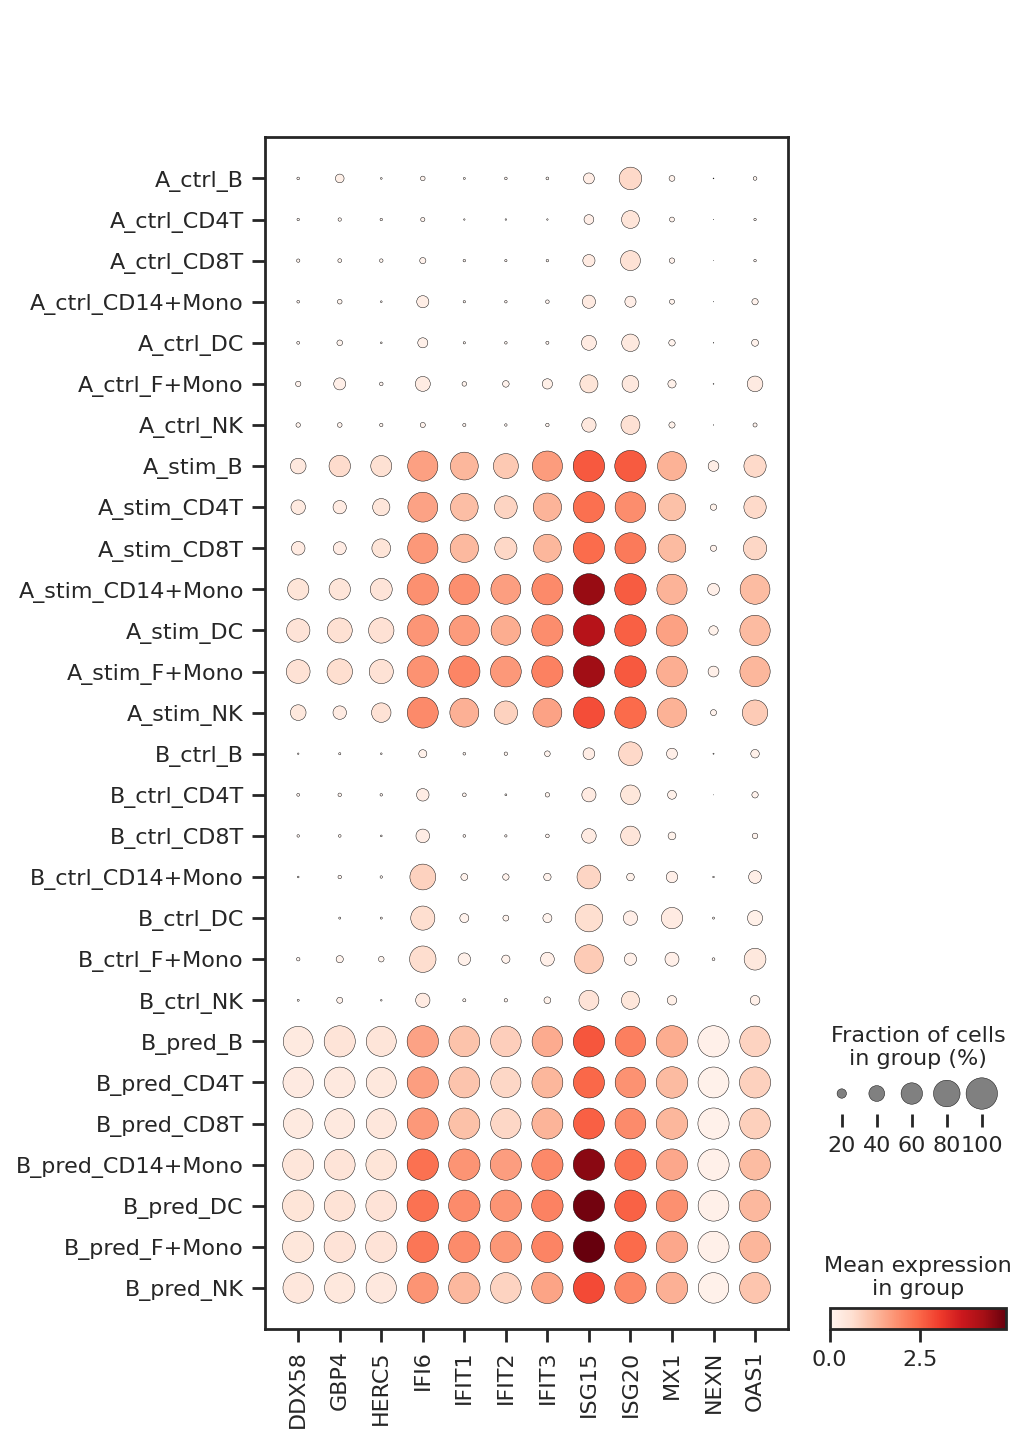

In [95]:
merge_list = [merge_A_data.copy(), merge_study_B_data.copy()]
merge_list[0].obs["condition_cell_type"] = "A_" + merge_list[0].obs["condition_cell_type"].astype("object")
merge_list[1].obs["condition_cell_type"] = "B_" + merge_list[1].obs["condition_cell_type"].astype("object")
sc.pl.dotplot(
    sc.concat(merge_list),
    var_names=sorted(common_diff_genes), 
    groupby="condition_cell_type", 
    save="_cross_study_predict_DEGs(all).pdf", 
    show=True
)